Document Preprocessing and Embedding

In [1]:
import os 
import requests
pdf_path = "human-nutrition-text.pdf"

if not os.path.exists(pdf_path):
    print(f"[Info] File doesn't exist , downloading ...")
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"
    file_name = pdf_path
    response = requests.get(url)
    if response.status_code == 200 : 
        with open(file_name , "wb") as file  : 
            file.write(response.content)
        print(f"[INFO] the file has been downloaded and saved as {file_name}")
    else : 
        print(f"[INFO Failed to download the file . Status Code : {response.status_code} ]")
else : 
    print(f"[INFO] file already exists")

[Info] File doesn't exist , downloading ...
[INFO] the file has been downloaded and saved as human-nutrition-text.pdf


In [3]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 61.7 MB/s eta 0:00:00:00:0100:01


In [4]:
import fitz
from tqdm import tqdm

def text_formatter(text:str) -> str : 
    cleaned_text = text.replace("\n"," ").strip()
    return cleaned_text
def open_read_pdf(pdf_path:str)->list[dict] : 
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number , page in tqdm(enumerate(doc)) : 
        text = page.get_text()
        text = text_formatter(text)
        pages_and_texts.append({"page_number" : page_number, 
                                "page_char_count" : len(text),                ## for exploratory data analysis
                                "page_word_count" : len(text.split(" ")),     ## for exploratory data analysis
                                "page_sentence_count" : len(text.split(".")), ## for exploratory data analysis
                                "page_token_count" : len(text)/4, ## every token consists of 4 chars              
                                "text":text})
        
    return pages_and_texts
pages_and_texts = open_read_pdf(pdf_path)
pages_and_texts[50]

1208it [00:01, 774.68it/s]


{'page_number': 50,
 'page_char_count': 1320,
 'page_word_count': 215,
 'page_sentence_count': 4,
 'page_token_count': 330.0,
 'text': 'Minerals  Major Functions  Macro  Sodium  Fluid balance, nerve transmission, muscle contraction  Chloride  Fluid balance, stomach acid production  Potassium  Fluid balance, nerve transmission, muscle contraction  Calcium  Bone and teeth health maintenance, nerve transmission,  muscle contraction, blood clotting  Phosphorus  Bone and teeth health maintenance, acid-base balance  Magnesium  Protein production, nerve transmission, muscle  contraction  Sulfur  Protein production  Trace  Iron  Carries oxygen, assists in energy production  Zinc  Protein and DNA production, wound healing, growth,  immune system function  Iodine  Thyroid hormone production, growth, metabolism  Selenium  Antioxidant  Copper  Coenzyme, iron metabolism  Manganese  Coenzyme  Fluoride  Bone and teeth health maintenance, tooth decay  prevention  Chromium  Assists insulin in glucose m

In [5]:
import pandas as pd 
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,text
0,0,29,4,1,7.25,Human Nutrition: 2020 Edition
1,1,0,1,1,0.00,
2,2,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,3,212,32,3,53.00,Human Nutrition: 2020 Edition by University of...
4,4,797,145,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [6]:
df.describe().round()

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count
count,1208.0,1208.0,1208.0,1208.0,1208.0
mean,604.0,1148.0,198.0,14.0,287.0
std,349.0,560.0,96.0,10.0,140.0
min,0.0,0.0,1.0,1.0,0.0
25%,302.0,762.0,134.0,8.0,190.0
50%,604.0,1232.0,214.0,13.0,308.0
75%,905.0,1604.0,271.0,19.0,401.0
max,1207.0,2308.0,429.0,82.0,577.0


Splitting pages into sentences

In [7]:
from spacy.lang.en import English
nlp = English()
## adding spacy sentencizer ==> split text into sentences (link to the doc : https://spacy.io/api/sentencizer)
sentencizer = nlp.add_pipe("sentencizer")
## doc instance for demonstration 
doc = nlp("this is a senteence . this is another one . A third one !")
assert len(list(doc.sents)) == 3
list(doc.sents)

[this is a senteence ., this is another one ., A third one !]

In [8]:
pages_and_texts[0]

{'page_number': 0,
 'page_char_count': 29,
 'page_word_count': 4,
 'page_sentence_count': 1,
 'page_token_count': 7.25,
 'text': 'Human Nutrition: 2020 Edition'}

In [9]:
for item in tqdm(pages_and_texts) : 
    item["sentences"] = list(nlp(item["text"]).sents) ## passing the text of each page to the sentencizer 
    item["sentences"] = [str(sentences) for sentences in item["sentences"]]
    item["page_sentence_count_spacy"] = len(item["sentences"]) 

100%|██████████| 1208/1208 [00:02<00:00, 594.98it/s]


In [10]:
pages_and_texts[1098]

{'page_number': 1098,
 'page_char_count': 1841,
 'page_word_count': 307,
 'page_sentence_count': 26,
 'page_token_count': 460.25,
 'text': 'harmful microorganisms that can cause foodborne illnesses.  Therefore, people who primarily eat raw foods should thoroughly  clean all fruit and vegetables before eating them. Poultry and other  meats should always be cooked before eating.12  Vegetarian and Vegan Diets  Vegetarian and vegan diets have been followed for thousands of  years for different reasons, including as part of a spiritual practice,  to show respect for living things, for health reasons, or because of  environmental concerns. For many people, being a vegetarian is a  logical outgrowth of “thinking green.” A meat-based food system  requires more energy, land, and water resources than a plant-based  food system. This may suggest that the plant-based diet is more  sustainable than the average meat-based diet in the U.S.By avoiding  animal flesh, vegetarians hope to look after thei

In [11]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,603.50,1148.00,198.30,14.18,287.00,10.32
std,348.86,560.38,95.76,9.54,140.10,6.30
min,0.00,0.00,1.00,1.00,0.00,0.00
25%,301.75,762.00,134.00,8.00,190.50,5.00
50%,603.50,1231.50,214.50,13.00,307.88,10.00
75%,905.25,1603.50,271.00,19.00,400.88,15.00
max,1207.00,2308.00,429.00,82.00,577.00,28.00


In [12]:
## chunking sentences together  
## we will into groups of 10 sentences
## LangChain , for examples , can help in chunking
num_sent_chunk_size = 10
## function to split lists of texts recursively into chunk size 
def split_list(input_list:list[str] , slice_size:int) -> list[list[str]] : 
    return [input_list[i:slice_size+i] for i in range(0,len(input_list),slice_size)]

In [13]:
test_list = list(range(25))
split_list(test_list , 10)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [14]:
for item in tqdm(pages_and_texts) : 
    item["sentence_chunks"] = split_list(input_list=item["sentences"] , slice_size=num_sent_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

100%|██████████| 1208/1208 [00:00<00:00, 241675.14it/s]


In [15]:
pages_and_texts[1000]

{'page_number': 1000,
 'page_char_count': 1487,
 'page_word_count': 246,
 'page_sentence_count': 12,
 'page_token_count': 371.75,
 'text': 'Sports Nutrition  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  Nutrient Needs for Athletes  Nutrition is essential to your performance during all types of  exercise. The foods consumed in your diet are used to provide  the body with enough energy to fuel an activity regardless of the  intensity of activity. Athletes have different nutritional needs to  support the vigorous level they compete and practice at.  Energy Needs  To determine an athletes nutritional needs, it is important to revisit  the concept of energy metabolism. Energy intake is the foundation  of an athlete’s diet because it supports optimal body functions,  determines the amount of intake of macronutrients and  micronutrients, and assists in the maintaining of body composition.  Energy needs for athletes increase depending on

In [16]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,603.50,1148.00,198.30,14.18,287.00,10.32,1.53
std,348.86,560.38,95.76,9.54,140.10,6.30,0.64
min,0.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,301.75,762.00,134.00,8.00,190.50,5.00,1.00
50%,603.50,1231.50,214.50,13.00,307.88,10.00,1.00
75%,905.25,1603.50,271.00,19.00,400.88,15.00,2.00
max,1207.00,2308.00,429.00,82.00,577.00,28.00,3.00


In [17]:
## splitting each chunk into its own item
## ==> embed each chunk of sentences into its own numerical representation
import re 
pages_and_chunks = []
for item in tqdm(pages_and_texts) : 
    for sentence_chunk in item["sentence_chunks"] :
        chunk_dict = {}
        chunk_dict["page_number"] =     item["page_number"]     
        joined_sentence_chunks = "".join(sentence_chunk).replace("  " , " ").strip()
        joined_sentence_chunks = re.sub(r'\.([A-Z])', r'. \1' , joined_sentence_chunks) ## .A ===> . A
        chunk_dict["sentence_chunk"] = joined_sentence_chunks
        
        chunk_dict["chunk_char_number"] = len(joined_sentence_chunks)
        chunk_dict["chunk_word_number"] = len([word for word in joined_sentence_chunks.split(" ")])
        chunk_dict["chunk_token_number"] = len(joined_sentence_chunks) / 4 ## 1 token ~ 4 chars
        pages_and_chunks.append(chunk_dict)

100%|██████████| 1208/1208 [00:00<00:00, 27860.85it/s]


In [18]:
len(pages_and_chunks)

1843

In [19]:
pages_and_chunks[500]

{'page_number': 348,
 'sentence_chunk': 'Image by Allison Calabrese / CC BY 4.0 \xa0 Fatty Acid Types in the Body The fatty-acid profile of the diet directly correlates to the tissue lipid profile of the body. It may not solely be the quantity of dietary fat that matters. More directly, the type of dietary fat ingested has been shown to affect body weight, composition, and metabolism. The fatty acids consumed are often incorporated into the triglycerides within the body. Evidence confirms that saturated fatty acids are linked to higher rates of weight retention when compared to other types of fatty acids. Alternatively, the How Lipids Work | 307',
 'chunk_char_number': 609,
 'chunk_word_number': 103,
 'chunk_token_number': 152.25}

In [20]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2) ## chunk_token_number max is 457 which above 384 (what our embedding model accept , so further work is needed with this detail)

,page_number,chunk_char_number,chunk_word_number,chunk_token_number
count,1843.00,1843.00,1843.00,1843.00
mean,624.38,734.44,112.33,183.61
std,347.79,447.54,71.22,111.89
min,0.00,12.00,3.00,3.00
25%,321.50,315.00,44.00,78.75
50%,627.00,746.00,114.00,186.50
75%,931.00,1118.50,173.00,279.62
max,1207.00,1831.00,297.00,457.75


In [21]:
## filter for very short chunks (have no meaning for our work : may not contain useful information)
min_token_length = 30
for row in df[df["chunk_token_number"]<= min_token_length].sample(5).iterrows() :
    print(f"chunk token count : {row[1]['chunk_token_number']} | Text : {row[1]['sentence_chunk']}")

chunk token count : 24.75 | Text : Table 9.33 Some Phytochemical’s Obtained from Diet and Their Related Functions 600 | Phytochemicals
chunk token count : 13.25 | Text : PART IX CHAPTER 9. VITAMINS Chapter 9. Vitamins | 513
chunk token count : 27.5 | Text : Iron Status and Exercise. The American Journal of Clinical Nutrition, 72(2), 594S–597S. Sports Nutrition | 967
chunk token count : 3.0 | Text : Iodine | 681
chunk token count : 16.5 | Text : http://www.aafp.org/afp/ 2002/1001/p1217.html. 862 | Toddler Years


In [22]:
## filter dataframe for rows with under 30 tokens 
pages_and_chunks_filtered = df[df["chunk_token_number"]>min_token_length].to_dict(orient="records")
pages_and_chunks_filtered[:2]

[{'page_number': 2,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_number': 308,
  'chunk_word_number': 42,
  'chunk_token_number': 77.0},
 {'page_number': 3,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_number': 210,
  'chunk_word_number': 30,
  'chunk_token_number': 52.5}]

##### From text chunks into numerical representation : Embedding
#####  embedding framework we are going to use : https://sbert.net/docs/installation.html

In [23]:
## the numerical representation of the text chunks is actually e *Learned* representation
from sentence_transformers import SentenceTransformer
emb_model = SentenceTransformer("all-mpnet-base-v2" , device="cpu")

test_data = [
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium."
    ]

embeddings = emb_model.encode(test_data)
print(embeddings)

2025-07-26 19:19:28.428050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753557568.605889      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753557568.653759      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[[-0.05405929 -0.01718496 -0.03553736 ...  0.02126813  0.04306808
  -0.01077988]
 [-0.06346937 -0.0316185  -0.01481562 ...  0.03250139 -0.02075413
   0.00200077]
 [-0.03902547  0.03801647  0.00174592 ... -0.01257585 -0.05982948
  -0.04102637]]


In [24]:
embeddings_dict = dict(zip(test_data , embeddings))
for sentence , emb in embeddings_dict.items():
    print(f"Sentence : {sentence}")
    print(f"Embedding : {emb}")
    print(f" ")

Sentence : The weather is lovely today.
Embedding : [-5.40592857e-02 -1.71849616e-02 -3.55373584e-02  5.00999242e-02
  2.86725396e-03 -3.25625464e-02 -5.80761731e-02  6.15104940e-03
  4.56210673e-02  1.85950398e-02 -4.00721617e-02  8.92390013e-02
 -2.16217227e-02 -3.36240344e-02  1.08703179e-02 -1.05172321e-01
  2.24103425e-02 -3.19909677e-02 -2.49627624e-02  1.63076948e-02
 -2.65984889e-03 -3.24465707e-02  3.21150534e-02 -3.25165242e-02
  5.64085431e-02 -1.06153917e-02 -1.73121169e-02  2.34713871e-02
  2.92384923e-02  2.48269327e-02 -5.33476584e-02 -4.08825316e-02
  6.37525320e-02 -4.49079648e-02  1.85175122e-06  1.37187000e-02
  2.81289201e-02 -2.68432102e-03  6.23045005e-02 -7.46229813e-02
 -1.49292573e-02 -2.04746556e-02 -1.56179648e-02  2.33425330e-02
 -6.32117561e-04  4.30108793e-02 -4.29194868e-02 -1.75441559e-02
 -2.68616658e-02  3.05798817e-02 -8.29362404e-03 -2.93245967e-02
 -3.83486338e-02  1.85985956e-02 -1.81627665e-02  2.91873850e-02
  2.34621968e-02 -6.75668195e-02  1.49

In [25]:
embeddings[0].shape

(768,)

In [ ]:
%%time
emb_model.to("cuda")

for item in tqdm(pages_and_chunks_filtered) : 
    item["embedding"] = emb_model.encode(item["sentence_chunk"])

In [27]:
%%time
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_filtered]
text_chunks_embeddings = emb_model.encode(text_chunks , batch_size=32, convert_to_tensor=True)

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

CPU times: user 25.4 s, sys: 71.9 ms, total: 25.5 s
Wall time: 23.6 s


In [28]:
text_chunks_embeddings[50]

tensor([ 3.2923e-02, -3.6203e-02,  9.6025e-03, -5.9295e-03,  4.9907e-02,
         4.8232e-02,  2.4192e-03,  4.4203e-02,  6.6855e-02, -5.9236e-02,
        -4.0920e-02,  1.1022e-02,  1.4030e-02, -2.6235e-02, -5.9962e-03,
         4.6343e-03, -6.6848e-03, -2.2288e-02, -1.6214e-02, -1.6422e-02,
        -2.1494e-02, -8.9056e-03,  3.2809e-03, -2.7728e-03, -4.3377e-02,
         1.3853e-03,  5.2277e-02, -1.7030e-02,  1.1127e-02, -2.5265e-02,
         5.3925e-03, -1.1638e-03,  2.3161e-02, -5.7264e-02,  2.2469e-06,
        -2.8888e-03, -2.1207e-02, -7.2799e-03, -6.0239e-02,  2.2344e-02,
         2.2962e-02, -6.6690e-02, -1.6562e-03, -5.6678e-03,  4.2398e-02,
         5.7974e-02,  2.6893e-03,  8.5898e-03, -4.9369e-03,  3.9629e-02,
         3.5413e-02,  6.1027e-02,  4.1460e-02,  6.5374e-02,  1.9681e-02,
         1.1993e-02,  1.4332e-02,  1.0003e-01,  6.1612e-04,  4.9408e-02,
         3.7746e-02,  5.7961e-03, -2.2947e-02,  2.6136e-02,  6.2787e-03,
         6.3203e-02, -4.6549e-02, -5.9518e-02, -1.0

In [29]:
pages_and_chunks_filtered[20]

{'page_number': 22,
 'sentence_chunk': 'Part\xa0XVIII.\xa0Chapter 18. Nutritional Issues Introduction University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 1043 Comparing Diets University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 1046 1.\xa0\xa0\xa0Calories In Versus Calories Out University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 1063 Nutrition, Health and Disease University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 1076 Threats to Health University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 1098 Undernutrition, Overnutrition, and Malnutrition University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 1121 Food Insecurity University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Pr

In [30]:
## save embeddings to file
text_chunks_embeddings_df = pd.DataFrame(pages_and_chunks_filtered)
save_file = "text_chunks_embeddings_df.csv"
text_chunks_embeddings_df.to_csv(save_file , index=False)

## RAG - Search and Answer  

RAG Goal : retrieve relevant passages based on the prompt given by the user (the prompt should be embedded with the same model used for embedding passages)
==> use these passages to augment an input into an LLM in order to generate an output based on on those relevant passages

In [31]:
# @@@@@@ Similarity (Vector) search @@@@@@
import random 
import torch 
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
text_chunks_embeddings_df = pd.read_csv("text_chunks_embeddings_df.csv")
text_chunks_embeddings_df["embedding"] = text_chunks_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]") ,sep=" "))
## text and embeddings ==> list of dicts 
pages_and_chunks = text_chunks_embeddings_df.to_dict(orient="records")
pages_and_chunks[5]

{'page_number': 7,
 'sentence_chunk': 'Indicators of Health: Body Mass Index, Body Fat Content, and Fat Distribution University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 133 Part\xa0III.\xa0Chapter 3. Water and Electrolytes Introduction University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 145 Overview of Fluid and Electrolyte Balance University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 150 Water’s Importance to Vitality University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 156 Regulation of Water Balance University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 162 Electrolytes Important for Fluid Balance University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program 172 Sodium University of Hawai‘i at Mānoa Food Science and

In [32]:
embeddings = torch.tensor(np.array(text_chunks_embeddings_df["embedding"].tolist()),dtype=torch.float32).to(device)
print(embeddings)
print(embeddings.shape)

tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')
torch.Size([1680, 768])


In [33]:
## create embedding model : 
from sentence_transformers import util,SentenceTransformer

embedding_model = SentenceTransformer("all-mpnet-base-v2",device=device)

In [34]:
## Semantic research pipeline
from time import perf_counter as timer
## defining the query
query = "Macronutrients functions"
print(f"Query : {query}")
## embedding the query
query_emb = embedding_model.encode(query,convert_to_tensor=True)
## Similarity scores with dot product 
start_time = timer()
dot_scores = util.dot_score(a=query_emb,b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings : {(end_time - start_time):.5f} seconds")

Query : Macronutrients functions


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Time taken to get scores on 1680 embeddings : 0.01353 seconds


In [35]:
print(dot_scores.shape)

## returning the top 5 scores 
top_5_scores = torch.topk(dot_scores,k=5)
print(f"Top 5 similarity scores : \n{top_5_scores}")

torch.Size([1680])
Top 5 similarity scores : 
torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))


In [36]:
### cosine similarity
cos_scores = util.pytorch_cos_sim(query_emb,embeddings)[0]
top_results = torch.topk(cos_scores,k=5)
print(f"Cosine Similarity top 5 scores : {top_5_scores}")

Cosine Similarity top 5 scores : torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))


In [37]:
print(f"Most matching : {pages_and_chunks[42]['sentence_chunk']} ")

Most matching : Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of carbon, hydrogen, and oxyg

In [38]:
import textwrap
def print_wrapped(text,wrap_length=80):
    wrapped_text = textwrap.fill(text,wrap_length)
    print(wrap_length)

In [39]:
print(f"Query : {query}")
print(f"Results\n")
for score , idx in zip(top_5_scores[0] , top_5_scores[1]) : 
    print(f"Score : {score:.4f}")
    print(f"Text : ")
    print(pages_and_chunks[idx]['sentence_chunk'])
    print(f"Page number : {pages_and_chunks[idx]['page_number']}")
    print(f"\n")

Query : Macronutrients functions
Results

Score : 0.6926
Text : 
Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are

In [40]:
doc_list = [item["sentence_chunk"] for item in pages_and_chunks]

In [ ]:
"""
## using a re-ranking model to improve the order of these results
from sentence_transformers import CrossEncoder
model = CrossEncoder("mixedbread-ai/mxbai-rerank-large-v1")
results = model.rank(query,doc_list,return_documents=True,top_k=5) 
"""

In [41]:
def dot_product(vec1,vec2): 
    return torch.dot(vec1,vec2)
def cosine_sim(vec1,vec2) : 
    dot_prod = dot_product(vec1,vec2)
    norm_vec1 = torch.sqrt(torch.sum(vec1**2))
    norm_vec2 = torch.sqrt(torch.sum(vec2**2))
    return dot_prod / (norm_vec1 * norm_vec2)
vector1 = torch.tensor([1,2,3],dtype=torch.float32)
vector2 = torch.tensor([4,5,6],dtype=torch.float32)
vector3 = torch.tensor([1,2,3],dtype=torch.float32)
vector4 = torch.tensor([-1,-2,-3],dtype=torch.float32)

print(f"dot product vec1 and vec2 : {dot_product(vector1,vector2)}")
print(f"dot product vec1 and vec3 : {dot_product(vector1,vector3)}")
print(f"dot product vec1 and vec4 : {dot_product(vector1,vector4)}")
print("")                                                               
print(f"Cosine Similarity vec1 and vec2 : {cosine_sim(vector1,vector2)}")
print(f"Cosine Similarity vec1 and vec3 : {cosine_sim(vector1,vector3)}")
print(f"Cosine Similarity vec1 and vec4 : {cosine_sim(vector1,vector4)}")

dot product vec1 and vec2 : 32.0
dot product vec1 and vec3 : 14.0
dot product vec1 and vec4 : -14.0

Cosine Similarity vec1 and vec2 : 0.9746317863464355
Cosine Similarity vec1 and vec3 : 0.9999999403953552
Cosine Similarity vec1 and vec4 : -0.9999999403953552


page 46 of human-nutrition-text.pdf


Text(0.5, 1.0, 'Query: Macronutrients functions | Most relevant page')

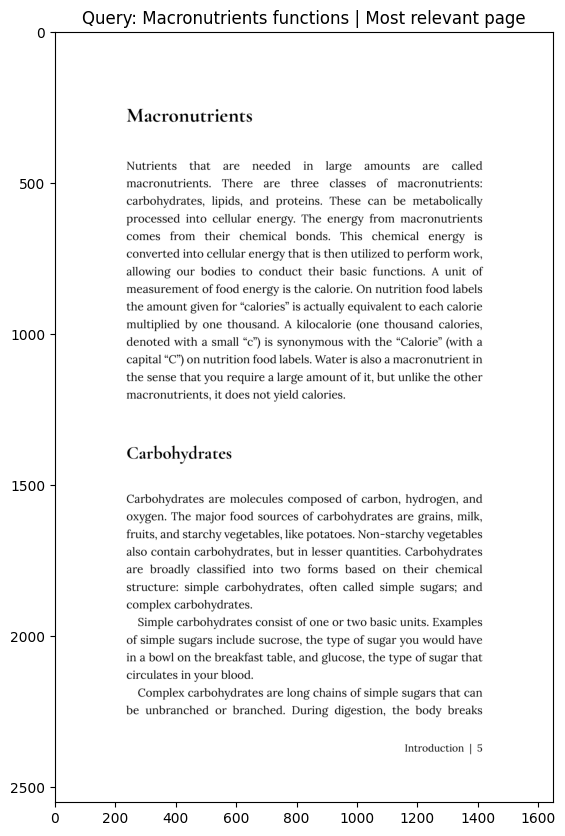

In [42]:
import fitz
pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(46)
print(page)
## get the image of the page
img = page.get_pixmap(dpi=300)
doc.close()
img_array = np.frombuffer(img.samples_mv,dtype=np.uint8).reshape((img.h,img.w,img.n))
import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query: {query} | Most relevant page")

In [43]:
def retrieve_relevant_resources(query:str,embeddings:torch.tensor,model:SentenceTransformer=embedding_model,n_resources_return:int=5):
     query_emb = model.encode(query,convert_to_tensor=True)
     start_time = timer()
     dot_scores = util.dot_score(a=query_emb,b=embeddings)[0]
     end_time = timer()
     print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings : {(end_time - start_time):.5f} seconds")
     scores , indices = torch.topk(dot_scores,k=n_resources_return)
     return scores , indices

def print_top_results_and_scores(query:str,embeddings:torch.tensor,pages_and_chunks:list[dict]=pages_and_chunks,n_resources_return:int=5) : 
     scores , indices = retrieve_relevant_resources(query,embeddings,n_resources_return=n_resources_return)
     print(f"Query : {query}")
     print(f"Results\n")
     for score , idx in zip(top_5_scores[0] , top_5_scores[1]) : 
          print(f"Score : {score:.4f}")
          print(f"Text : ")
          print(pages_and_chunks[idx]['sentence_chunk'])
          print(f"Page number : {pages_and_chunks[idx]['page_number']}")
          print(f"\n")

In [44]:
print_top_results_and_scores("foods high in fiber" , embeddings , pages_and_chunks=pages_and_chunks)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Time taken to get scores on 1680 embeddings : 0.00018 seconds
Query : foods high in fiber
Results

Score : 0.6926
Text : 
Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrie

## Getting LLM for our local RAG

In [45]:
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes/(2**30))
print(f"Available GPU memory : {gpu_memory_gb} GB")

Available GPU memory : 15 GB


In [46]:
!nvidia-smi

Sat Jul 26 19:21:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P0             29W /   70W |    1565MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [47]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


In [52]:
from transformers import AutoTokenizer, AutoModelForCausalLM ## generative model
from transformers.utils import is_flash_attn_2_available
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True , bnb_4bit_compute_dtype=torch.float16)


In [53]:
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0]>=8) : 
    attn_mechanism = "flash_attention_2"
else : 
    attn_mechanism = "sdpa"
print(f"Attention mechanism : {attn_mechanism}")

Attention mechanism : sdpa


In [56]:
### defining the model to be used
print(f"Model : {model_id}")

### defining the tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)
### LLM Model

llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                torch_dtype=torch.float16,
                                                quantization_config = quantization_config if use_quantization_config else None,
                                                low_cpu_mem_usage=False,
                                                attn_implementation=attn_mechanism)

Model : google/gemma-2b-it


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [57]:
!nvidia-smi

Sat Jul 26 19:27:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             29W /   70W |    1565MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [58]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): GemmaRMSNorm((2048,), 

In [59]:
def get_model_num_params(model : torch.nn.Module) : 
    return sum([param.numel() for param in model.parameters()])
get_model_num_params(llm_model)

2506172416

In [60]:
def get_model_mem_size(model : torch.nn.Module) : 
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()]) 
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()]) 

    model_mem_bytes =  mem_buffers + mem_params
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)
    return round(model_mem_gb,2)
get_model_mem_size(llm_model)

4.67

## Generating text with LLM

In [61]:
input_text = "what are the macronutrients , and what roles do they play in the human body"
print(f"Input text : {input_text}")

dialogue_template = [{
    "role":"user",
    "content":input_text
}]

prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                      tokenize=False,
                                       add_generation_prompt=True)

print(f"\nPrompt (formatted) :\n{prompt}")

Input text : what are the macronutrients , and what roles do they play in the human body

Prompt (formatted) :
<bos><start_of_turn>user
what are the macronutrients , and what roles do they play in the human body<end_of_turn>
<start_of_turn>model



In [62]:
%%time
input_ids = tokenizer(prompt , return_tensors="pt").to("cuda")
input_ids

CPU times: user 1.3 ms, sys: 795 µs, total: 2.1 ms
Wall time: 3.2 ms


{'input_ids': tensor([[     2,      2,    106,   1645,    108,   5049,    708,    573, 186809,
         184592,   1688,    578,   1212,  16065,    749,    984,   1554,    575,
            573,   3515,   2971,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]], device='cuda:0')}

In [63]:
## generate output using our local LLM
llm_model.to("cuda")
outputs = llm_model.generate(**input_ids,max_new_tokens=256)
print(f"Model output:\n{outputs}")

Model output:
tensor([[     2,      2,    106,   1645,    108,   5049,    708,    573, 186809,
         184592,   1688,    578,   1212,  16065,    749,    984,   1554,    575,
            573,   3515,   2971,    107,    108,    106,   2516,    108,  21404,
         235269,   1517, 235303, 235256,    476,  25497,    576,    573, 186809,
         184592,    578,   1024,  16065,    575,    573,   3515,   2971, 235292,
            109,    688,  12298,   1695, 184592,  66058,    109, 235287,   5231,
         156615,  56227,  66058,    108,    141, 235287,  34428,   4134,    604,
            573,   2971, 235303, 235256,   5999,    578,  29703, 235265,    108,
            141, 235287, 110165,  56227,    708,    573,   7920,   4303,    576,
           4134,    604,   1546,   5999, 235265,    108,    141, 235287,  25280,
          72780,    708,   1941,    674,   1987,   5543,    577,  55997, 235269,
           1582,    685,   3733,  29907, 235269,  16803, 235269,    578,  19574,
         23526

In [64]:
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Decoded Output:\n{outputs_decoded}")

Decoded Output:
<bos><bos><start_of_turn>user
what are the macronutrients , and what roles do they play in the human body<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of the macronutrients and their roles in the human body:

**Macronutrients:**

* **Carbohydrates:**
    * Provide energy for the body's cells and tissues.
    * Carbohydrates are the primary source of energy for most cells.
    * Complex carbohydrates are those that take longer to digest, such as whole grains, fruits, and vegetables.
    * Simple carbohydrates are those that are quickly digested, such as sugar, starch, and lactose.

* **Proteins:**
    * Build and repair tissues, enzymes, and hormones.
    * Proteins are essential for immune function, hormone production, and tissue repair.
    * There are different types of proteins, each with specific functions.

* **Fats:**
    * Provide energy, insulation, and help absorb vitamins.
    * Healthy fats include olive oil, avocado, nuts, and seeds.
    * Tran

In [65]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [66]:
import random 
query = random.choice(query_list)
print(f"Query: {query}")
scores , indices = retrieve_relevant_resources(query,embeddings)

Query: What are the macronutrients, and what roles do they play in the human body?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Time taken to get scores on 1680 embeddings : 0.00021 seconds


In [67]:
scores , indices

(tensor([0.7302, 0.7233, 0.6962, 0.6942, 0.6416], device='cuda:0'),
 tensor([42, 47, 46, 41, 52], device='cuda:0'))

In [95]:
## Augmenting the prompt with context items
def prompt_design(query:str,context_items:list[dict]) -> str : 
    context = "- " +"\n- ".join([item["sentence_chunk"] for item in context_items])
    base_prompt ="""Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""
    base_prompt = base_prompt.format(context=context, 
                                    query=query)
    dialogue_template= [{
        "role":"user",
        "content":base_prompt
    }]

    
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [102]:
query = random.choice(query_list)
scores , indices = retrieve_relevant_resources(query,embeddings)
context_items = [pages_and_chunks[i] for i in indices]

## formatting the prompt
prompt = prompt_design(query,context_items)
print(f"Formatted Prompt :\n{prompt}")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Time taken to get scores on 1680 embeddings : 0.00014 seconds
Formatted Prompt :
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.

Example 

In [103]:
%%time
input_ids = tokenizer(prompt,return_tensors="pt").to("cuda")
outputs = llm_model.generate(**input_ids,
                            temperature=0.7,
                            do_sample=True,
                            max_new_tokens=256)
output_text = tokenizer.decode(outputs[0])
print(f"Query : {query}")
print(f"RAG Answer :\n{output_text.replace(prompt, '')}")

Query : Describe the process of digestion and absorption of nutrients in the human body.
RAG Answer :
<bos>Sure, here's a summary of the process of digestion and absorption of nutrients in the human body:

**Step 1: The Process Begins in the Mouth**

- When we feel hungry, our bodies send a message to the brain that we need food.
- The brain interprets this message and triggers the release of digestive hormones and salivary amylase, an enzyme that starts breaking down starches into smaller molecules.

**Step 2: The Food Journey through the Digestive System**

- The small molecules from the food are then broken down into smaller and smaller molecules by enzymes in the mouth, stomach, and intestines.
- The process also involves the mixing and churning of the food by the tongue, muscles, and saliva.

**Step 3: Absorption of Nutrients**

- Once the nutrients are broken down and dissolved into the digestive juices, they are absorbed through the walls of the digestive tract.
- The digestive 

In [104]:
## Putting it all together
def ask(query:str,temperature:float=0.7,
       max_new_tokens:int=256,
       format_answer_text=True,
       return_answer_only=True):
    scores , indices = retrieve_relevant_resources(query,embeddings)
    context_items    = [pages_and_chunks[i] for i in indices]
    
    for i,item in enumerate(context_items) : 
        item["score"] = scores[i].cpu()
    prompt = prompt_design(query,context_items)
    input_ids = tokenizer(prompt,return_tensors="pt").to("cuda")
    outputs = llm_model.generate(**input_ids,
                            temperature=temperature,
                            do_sample=True,
                            max_new_tokens=max_new_tokens)
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text :
        output_text = output_text.replace(prompt, '').replace("<bos>","").replace("<eos>","")
    if return_answer_only :
        return output_text
    return output_text , context_items
        
        

In [114]:
query = random.choice(query_list)
print(f"Query : {query}")
ask(query)

Query : Describe the process of digestion and absorption of nutrients in the human body.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Time taken to get scores on 1680 embeddings : 0.00023 seconds


"Sure, here's a summary of the process of digestion and absorption of nutrients in the human body:\n\n**Step 1: Food Intake**\n\n* The process begins when the sense of hunger signals the brain. \n* This triggers the release of hormones, including growth hormone, which stimulate the digestive system to break down food molecules into smaller components. \n* The digestive system consists of several organs including the mouth, pharynx, esophagus, stomach, small intestine, large intestine (colon), rectum, and anus. \n\n**Step 2: Mechanical Digestion**\n\n* The food particles are then moved and mixed by the muscles of the digestive tract. \n* This involves the physical breakdown of food molecules into smaller fragments. \n* The process of breaking down food molecules into smaller components helps to make them more easily absorbed.\n\n**Step 3: Chemical Digestion**\n\n* Once the food molecules have been broken down into smaller fragments, they are then broken down into even smaller molecules 